In [11]:
import pandas as pd
import numpy as np
import mlflow
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def info(data: pd.DataFrame):
    '''
    Gives Insights to the Data.
    '''
    print('\033[1mData describe: \n \033[0;0m')
    print(data.describe())
    print('------------------------------------\n')
    print('\033[1mData info: \n \033[0;0m')
    print(data.info())
    print('------------------------------------\n')
    print('\033[1mNulls in Data: \n \033[0;0m')
    print(data.isnull().sum())
    print('------------------------------------\n')
    print('\033[1mCorrelation in Heatmap: \n \033[0;0m')
    plt.figure(figsize=(12,12))
    sns.heatmap(data.corr(), annot=True)
    plt.show()

def reduction(data: pd.DataFrame):
    '''
    This function reduced the dataset to 2 Components with Principal Component Analysis and returns the data.
    '''
    global dataset
    pca = PCA(n_components=2, svd_solver='auto')
    B = pca.fit_transform(data)
    dataset = pd.DataFrame({'Column1': B[:, 0], 'Column2': B[:, 1]})
    return [dataset]


def newdata(data: pd.DataFrame):
    '''
    Enegeneering new Data and Dropping nan-Values.
    '''
    global newdata
    
    data['PERCETAGE_OF_LIMIT'] = data['BALANCE']/ data['CREDIT_LIMIT']
    data['FREQUENCY'] = data['BALANCE_FREQUENCY']*data['PURCHASES_FREQUENCY']
    data['PURCHASE'] = data['ONEOFF_PURCHASES']/data['PURCHASES']  
    data['PURCHASE'] = data['PURCHASE'].fillna(0)
    data= data.drop(['CUST_ID',
                     'ONEOFF_PURCHASES',
                     'INSTALLMENTS_PURCHASES',
                     'TENURE', 
                     'PRC_FULL_PAYMENT', 
                     'CASH_ADVANCE',
                     'MINIMUM_PAYMENTS',
                     'CASH_ADVANCE_TRX',
                     'PURCHASES_TRX',
                     'PAYMENTS',
                     'PURCHASES_INSTALLMENTS_FREQUENCY'], axis= 1)
    newdata= data.dropna()
    return [newdata]

def split(data: pd.DataFrame):
    '''
    Splitting the Dataset to:
    
    X_Train: 70%
    X_Test: 20%
    X_Val: 10%
    '''
    global X_Train, X_Test, X_Val
    
    X_Train, X =train_test_split(data, test_size= 0.3, random_state=0)
    X_Test, X_Val =train_test_split(X, test_size= 1/3, random_state=0)
    
    return [X_Train, X_Test, X_Val]
    
def clustering(X: pd.DataFrame, X_Test: pd.DataFrame, n_clusters: int):
    

    with mlflow.start_run() as run:
        model = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++')
        model.fit(X)
        
        
        prediction = model.predict(X_Test)
        
        #silhouette_score = silhouette_score(X_Test, prediction)
        #calinski_harabasz_score= calinski_harabasz_score(X_Test, prediction)
        #davies_bouldin_score = davies_bouldin_score(X_Test, prediction)
        mlflow.log_metric('davies_bouldin_score', davies_bouldin_score(X_Test, prediction))
        mlflow.log_metric('calinski_harabasz_score', calinski_harabasz_score(X_Test, prediction))
        mlflow.log_metric('silhouette_score', silhouette_score(X_Test, prediction))
        mlflow.log_metric('inertia_', model.inertia_)
        params = {'n_clusters': n_clusters}
        mlflow.log_params(params)
        
        mlflow.sklearn.log_model(model, "model")

def elbow(X: pd.DataFrame):
    '''
    Just for personal Usage.
    The Elbowmethode shows the optimal k. 
    '''
    from yellowbrick.cluster import KElbowVisualizer
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,20))

    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()

In [13]:
data= pd.read_csv('./data/CC_GENERAL.csv', sep = ',')

In [14]:
newdata(data)

[          BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
 0       40.900749           0.818182      95.40             0.166667   
 1     3202.467416           0.909091       0.00             0.000000   
 2     2495.148862           1.000000     773.17             1.000000   
 3     1666.670542           0.636364    1499.00             0.083333   
 4      817.714335           1.000000      16.00             0.083333   
 ...           ...                ...        ...                  ...   
 8945    28.493517           1.000000     291.12             1.000000   
 8946    19.183215           1.000000     300.00             1.000000   
 8947    23.398673           0.833333     144.40             0.833333   
 8948    13.457564           0.833333       0.00             0.000000   
 8949   372.708075           0.666667    1093.25             0.666667   
 
       ONEOFF_PURCHASES_FREQUENCY  CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT  \
 0                       0.000000              

Data describe: 
 
            BALANCE  BALANCE_FREQUENCY     PURCHASES  PURCHASES_FREQUENCY  \
count   8949.000000        8949.000000   8949.000000          8949.000000   
mean    1564.647593           0.877350   1003.316936             0.490405   
std     2081.584016           0.236798   2136.727848             0.401360   
min        0.000000           0.000000      0.000000             0.000000   
25%      128.365782           0.888889     39.800000             0.083333   
50%      873.680279           1.000000    361.490000             0.500000   
75%     2054.372848           1.000000   1110.170000             0.916667   
max    19043.138560           1.000000  49039.570000             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT  \
count                 8949.000000             8949.000000   8949.000000   
mean                     0.202480                0.135141   4494.449450   
std                      0.298345                0.200132   363

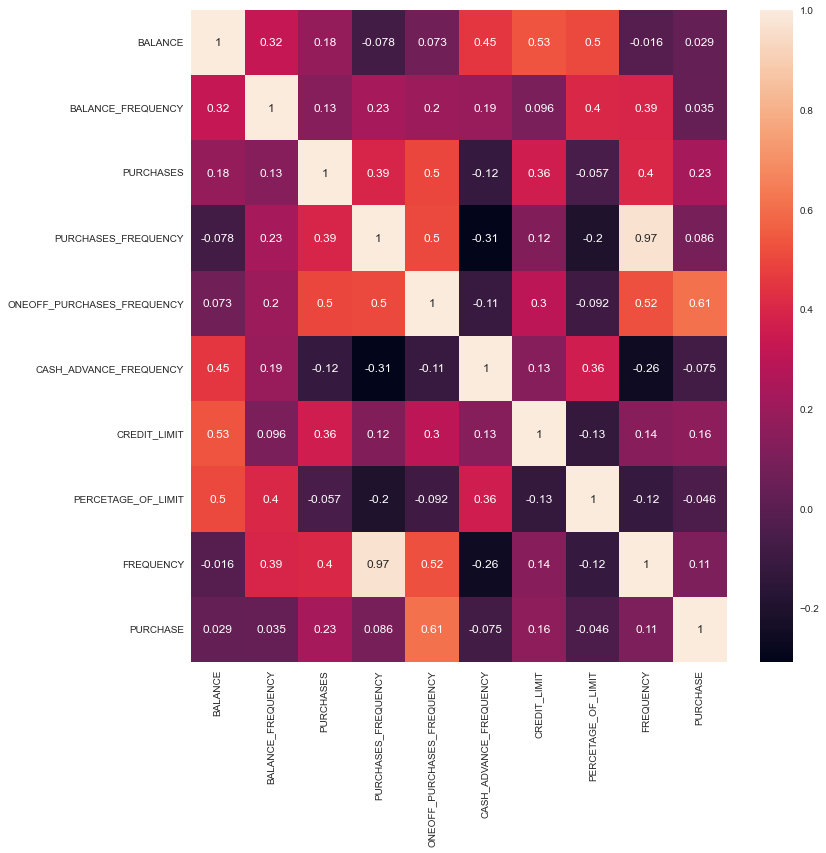

In [15]:
info(newdata)

#Give some Insights to the data

In [16]:
reduction(newdata) #Perform the PCA

[          Column1      Column2
 0    -3913.421926   126.237729
 1     2573.055020 -1810.839577
 2     2978.996964  -953.530935
 3     2879.157241   -28.205550
 4    -3486.343241  -204.636870
 ...           ...          ...
 8944 -3868.002530   314.689893
 8945 -3868.940954   325.771665
 8946 -3906.986606   177.584449
 8947 -4399.269132   121.739345
 8948 -3365.515148   941.633381
 
 [8949 rows x 2 columns]]

Data describe: 
 
            Column1       Column2
count  8.949000e+03  8.949000e+03
mean   6.244201e-13 -2.926969e-13
std    3.942754e+03  1.965243e+03
min   -4.704935e+03 -6.890300e+03
25%   -2.964899e+03 -6.693447e+02
50%   -1.230441e+03 -1.051446e+02
75%    1.927276e+03  4.008321e+02
max    3.189940e+04  3.968522e+04
------------------------------------

Data info: 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Column1  8949 non-null   float64
 1   Column2  8949 non-null   float64
dtypes: float64(2)
memory usage: 140.0 KB
None
------------------------------------

Nulls in Data: 
 
Column1    0
Column2    0
dtype: int64
------------------------------------

Correlation in Heatmap: 
 


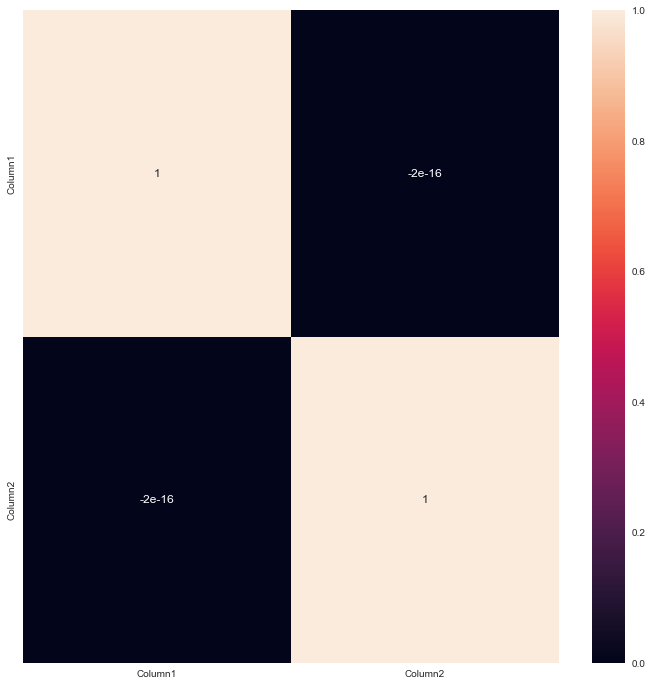

In [17]:
info(dataset)

In [18]:
split(dataset)
#Splitting the Dataset

[          Column1      Column2
 371   6681.891477 -2335.221020
 2495  -476.710246   -78.176579
 5671 -3367.828953   366.747818
 3448  1682.255731 -1667.029795
 2645  9331.151609 -3696.863206
 ...           ...          ...
 4373 -1141.230647  -104.281257
 7891 -1035.601874   296.894152
 4859  5631.904583 -1308.693962
 3264  7127.183614 -3830.606565
 2732 -2638.776182  1711.196736
 
 [6264 rows x 2 columns],
           Column1      Column2
 5450 -1817.484504  -841.304002
 8090 -2972.703309   110.442121
 2551  -926.926113  1787.691969
 4931   588.714146  -674.464689
 6942  1410.013750 -1741.284386
 ...           ...          ...
 6692   401.787663  3376.713557
 651   -829.000197   600.452358
 2513 -3109.455190  -324.109651
 4126  1140.861596  2612.556272
 7609 -3443.528433   360.314009
 
 [1790 rows x 2 columns],
            Column1      Column2
 3233  -2739.037194   335.715886
 7163  -3667.384686   323.251651
 472    2357.198922    93.645518
 6158  -2768.593614  -524.967881
 188   -214

In [19]:
for k in range(2, 20):
    clustering(X_Train, X_Test, k)

#Run the Clustering for k in Range 2 to 20

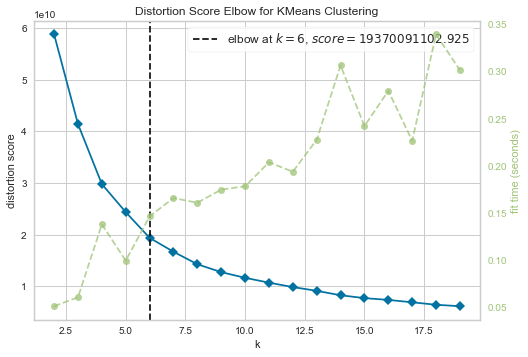

In [20]:
elbow(X_Train)
#Executing the Elbow Methode